In [1]:
import os
import torch
import numpy as np
import cv2
from torchvision import datasets
from torchvision.transforms import ToTensor,v2,Grayscale
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torch.nn as nn
from torchsummary import summary
from torch.utils.data.dataloader import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from PIL import Image 
from torch.utils.data import SubsetRandomSampler, random_split ,ConcatDataset
from sklearn.metrics import confusion_matrix,roc_auc_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

os.environ['CUDA_LAUNCH_BLOCKING']='1'

cuda


In [3]:
data_path = f"./data"

transform = v2.Compose([
    v2.Resize((128, 128),interpolation=cv2.INTER_AREA),
    Grayscale(),
    ToTensor(),
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_folder = ImageFolder(data_path,transform = transform)
print(image_folder.class_to_idx)
print(image_folder)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Dataset ImageFolder
    Number of datapoints: 790
    Root location: ./data
    StandardTransform
Transform: Compose(
                 Resize(size=[128, 128], interpolation=InterpolationMode.BICUBIC, antialias=warn)
                 Grayscale(num_output_channels=1)
                 ToTensor()
           )


In [4]:
data2_path = f"./black0-4"

image_folder2 = ImageFolder(data2_path,transform = transform)

concat_dataset = ConcatDataset([image_folder, image_folder2])

In [5]:
validation_ratio = 0.2

# 計算分割的大小
num_samples = len(image_folder2)
num_validation = int(validation_ratio * num_samples)
num_train = num_samples - num_validation

# 使用 random_split 函數進行隨機分割
train_dataset, validation_dataset = random_split(image_folder2, [num_train, num_validation])

# 創建 DataLoader 以加載資料集
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=64)

In [6]:
print([num_train, num_validation])
print(len(image_folder))
print(len(train_dataset))
print(len(validation_dataset))

[968, 242]
790
968
242


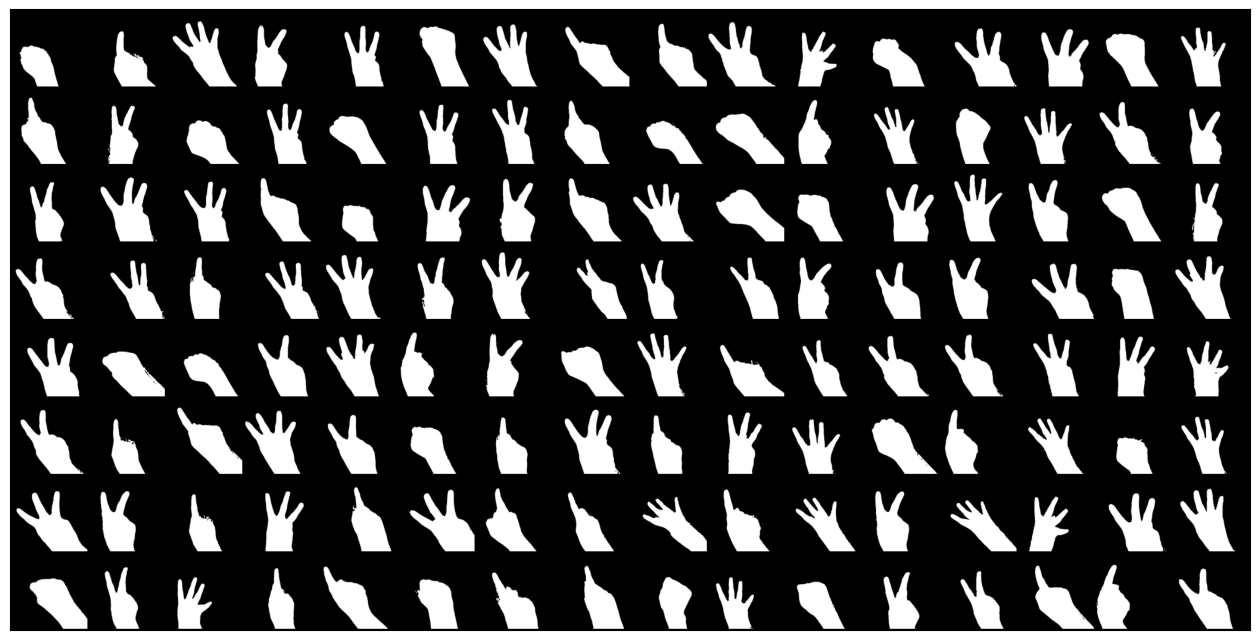

In [7]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
show_batch(train_dataloader)

In [8]:
def one_hot_label(original_labels):
    num_classes = 5  
    one_hot_labels = np.zeros((len(original_labels), num_classes))
    for i, label in enumerate(original_labels):
        one_hot_labels[i, label] = 1
    return torch.tensor(one_hot_labels)

In [9]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        one_hot_labels = one_hot_label(labels)
        images=images.to(device)
        one_hot_labels = one_hot_labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, one_hot_labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        one_hot_labels = one_hot_label(labels)
        images=images.to(device)
        labels=labels.to(device)
        one_hot_labels = one_hot_labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, one_hot_labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result,scheduler):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))
        scheduler.step(result['val_loss']) 

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor =0.1, patience =5,verbose=True)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()   
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result,scheduler)
        history.append(result)
    
    return history

In [11]:
class ImageClassifier(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
          nn.Conv2d(1, 16, 3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2))
        self.conv_layer_2 = nn.Sequential(
          nn.Conv2d(16, 32, 3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2),
          nn.Dropout(0.2))
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=32*30*30, out_features=128),
          nn.ReLU(),
          nn.Dropout(0.05),
          nn.Linear(in_features=128, out_features=5))
    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.classifier(x)
        return x

In [12]:
model = ImageClassifier()
model.to(device)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]             160
              ReLU-2         [-1, 16, 126, 126]               0
         MaxPool2d-3           [-1, 16, 63, 63]               0
            Conv2d-4           [-1, 32, 61, 61]           4,640
              ReLU-5           [-1, 32, 61, 61]               0
         MaxPool2d-6           [-1, 32, 30, 30]               0
           Dropout-7           [-1, 32, 30, 30]               0
           Flatten-8                [-1, 28800]               0
            Linear-9                  [-1, 128]       3,686,528
             ReLU-10                  [-1, 128]               0
          Dropout-11                  [-1, 128]               0
           Linear-12                    [-1, 5]             645
Total params: 3,691,973
Trainable params: 3,691,973
Non-trainable params: 0
---------------------------

In [13]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dataloader, validation_dataloader, opt_func)

Epoch [1], train_loss: 1.7310, val_loss: 1.4733, val_acc: 0.3786
Epoch [2], train_loss: 1.2725, val_loss: 1.1585, val_acc: 0.6294
Epoch [3], train_loss: 0.9014, val_loss: 0.8164, val_acc: 0.7236
Epoch [4], train_loss: 0.5990, val_loss: 0.6026, val_acc: 0.7905
Epoch [5], train_loss: 0.4090, val_loss: 0.4809, val_acc: 0.8573
Epoch [6], train_loss: 0.2825, val_loss: 0.2838, val_acc: 0.9019
Epoch [7], train_loss: 0.2041, val_loss: 0.2367, val_acc: 0.9186
Epoch [8], train_loss: 0.1432, val_loss: 0.1823, val_acc: 0.9431
Epoch [9], train_loss: 0.0974, val_loss: 0.1453, val_acc: 0.9570
Epoch [10], train_loss: 0.0681, val_loss: 0.1105, val_acc: 0.9766


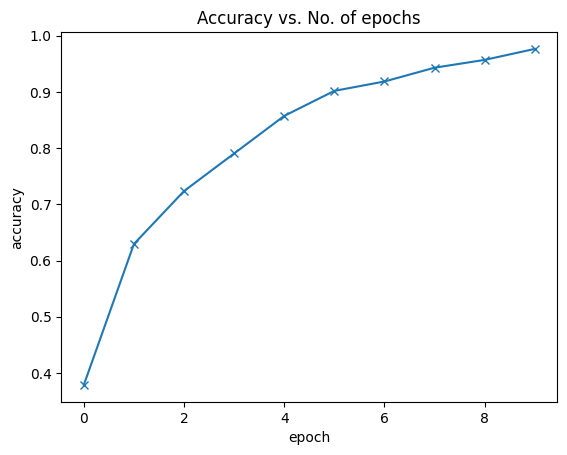

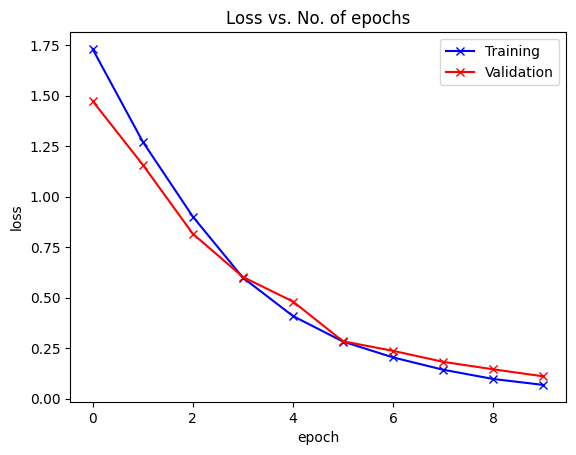

In [16]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)
plt.figure()
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [17]:
torch.save(model.state_dict(),"./weight/black0-4(99).pth")